In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from numpy.core.arrayprint import repr_format
import functools, copy

In [4]:
# constants
SQRT_2 = np.sqrt(2)

In [5]:
def resizeInput(src):
    resized = cv.resize(src, None, fx=0.5, fy=0.5, interpolation=cv.INTER_CUBIC)
    return resized

In [6]:
SQRT_2 = np.sqrt(2)

class HaarFeature:
    def __init__(self, r1, r2) -> None:
        self.r_inner = r1
        self.r_outer = r2

        count_inner = self.r_inner ** 2
        count_outer = self.r_outer ** 2 - self.r_inner ** 2
        self.val_inner = 1.0 / (self.r_inner ** 2)
        self.val_outer = -self.val_inner * count_inner / count_outer


In [12]:
# roi: y0 x0 y1 x1
def getROI(src, roi, dst=None):
    x0 = 0
    y0 = 0
    y1 = src.shape[0]
    x1 = src.shape[1]
    top = 0
    bottom = 0
    left = 0
    right = 0
    if roi[0] < 0 or roi[1] < 0 or roi[2] > src.shape[0] or roi[3] > src.shape[1]:
        dst = copy.deepcopy(src)
        if roi[0] < 0:
            top = -roi[0]
        if roi[1] < 0:
            left = -roi[1]
        if roi[2] > src.shape[0]:
            bottom = roi[2] - src.shape[0]
        if roi[3] > src.shape[1]:
            right = roi[3] - src.shape[1]
        dst = cv.copyMakeBorder(dst, top, bottom, left, right, cv.BORDER_REPLICATE)
    else: dst = src[y0:y1, x0:x1, :]
    return dst
        

def findPupilEllipse(img: np.ndarray, pupilParams, out):
    padding = 2 * pupilParams.r_max
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # expand img to allow haar kernel to scan all edges without out-of-bound cases.
    imgPad = cv.copyMakeBorder(gray, padding, padding, padding, padding, cv.BORDER_REPLICATE)
    integral = cv.integral(imgPad)

    haarRadius = 0
    rstep = 2
    ystep = 4
    xstep = 4

    minResponse = np.Infinity
    minValPoint = []
    minValIn = [minResponse, minValPoint, 0]
    minValOut = copy.deepcopy(minValIn)
    pHaarPupil = ()

    # for each iteration of ellipse with radius r,
    # calculate the sums of inner and outer areas of the haar feature
    for r in range(pupilParams.r_min, pupilParams.r_max, rstep):
        r_inner = r
        r_outer = 3*r
        hf = HaarFeature(r_inner, r_outer)

        # **unoptimized**
        for y in range(0, (img.shape[0] - r - r -1)//ystep + 1, ystep):
            # original illustration of haar kernel and corresponding points, too good not to copy.
            # row1_outer.|         |  p00._____________________.p01
            #            |         |     |         Haar kernel |
            #            |         |     |                     |
            # row1_inner.|         |     |   p00._______.p01   |
            #            |-padding-|     |      |       |      |
            #            |         |     |      | (x,y) |      |
            # row2_inner.|         |     |      |_______|      |
            #            |         |     |   p10'       'p11   |
            #            |         |     |                     |
            # row2_outer.|         |     |_____________________|
            #            |         |  p10'                     'p11

            upper_inner = integral[y + padding - r_inner]
            lower_inner = integral[y + padding + r_inner + 1]
            upper_outer = integral[y + padding - r_outer]
            lower_outer = integral[y + padding + r_outer + 1]

            p00_inner = upper_inner[r + padding - r_inner]
            p01_inner = upper_inner[r + padding + r_inner + 1]
            p10_inner = lower_inner[r + padding - r_inner]
            p11_inner = lower_inner[r + padding + r_inner + 1]

            p00_outer = upper_outer[r + padding - r_outer]
            p01_outer = upper_outer[r + padding + r_outer + 1]
            p10_outer = lower_outer[r + padding - r_outer]
            p11_outer = lower_outer[r + padding + r_outer + 1]
            
            for x in range(r, img.shape[1] - r, xstep):
                sumInner = p00_inner + p11_inner - p01_inner - p10_inner
                sumOuter = p00_outer + p11_outer - p01_outer - p10_outer - sumInner

                response = hf.val_inner * sumInner + hf.val_outer * sumOuter

                if (response < minResponse):
                    minValOut[0] = response
                    minValOut[1] = (x, y)
                
                p00_inner += xstep
                p01_inner += xstep
                p10_inner += xstep
                p11_inner += xstep

                p00_outer += xstep
                p01_outer += xstep
                p10_outer += xstep
                p11_outer += xstep
        if (minValOut[0] < minResponse):
            minResponse = minValOut[0]
            pHaarPupil = minValOut[1]
            minValOut[2] = haarRadius = r
            print(response)
    
    haarRadius = (int)(haarRadius * SQRT_2)

    roiHaarPupil = (pHaarPupil[1]-r, pHaarPupil[0]-r, pHaarPupil[1]+r, pHaarPupil[0]+r) # y0 x0 y1 x1
    mHaarPupil = getROI(img, roiHaarPupil)

    # calculate histogram of pupil
    hist = cv.calcHist(mHaarPupil, [1], None, [256], (0, 256))

    return (roiHaarPupil, mHaarPupil, hist, minValOut)


In [21]:
# capture one frame for sample
# cap = cv.VideoCapture('F:\\LEONLAH\\myprojects\\dyslexia_eyetracking\\docs\\eyesmaple-d.jpg')
cap = cv.VideoCapture('C:\\LEONLAH\\myprojects\\dyslexia_eyetracking\\docs\\eyesample-2.jpg')
_, frame = cap.read()
cap.release()
frame = resizeInput(frame)
frame = frame[0:frame.shape[0], 0:(int)(frame.shape[1]*0.8), :]

In [22]:
class pupilParams:
    def __init__(self):
        self.r_min = 50
        self.r_max = 100
    
    def setparam(self, min, max):
        self.r_max = max
        self.r_min = min

pp = pupilParams()
roiHaarPupil, mHaarPupil, hist, minRes = findPupilEllipse(frame, pp, None)

-41.045349999999985
-42.68500369822482
-42.84799382716051
-43.49669164540819
-43.737997919143936


In [128]:
padding = 2 * 10
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
# expand img to allow haar kernel to scan all edges without out-of-bound cases.
imgPad = cv.copyMakeBorder(gray, padding, padding, padding, padding, cv.BORDER_REPLICATE)
integral = cv.integral(imgPad)

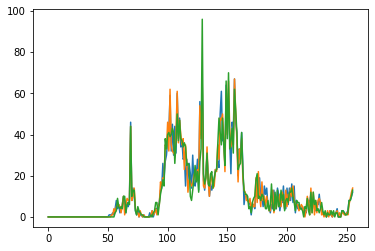

In [20]:
histSize = [256]
histRange = (0, 256)
b_hist = cv.calcHist(mHaarPupil, [0], None, histSize, histRange, accumulate=False)
g_hist = cv.calcHist(mHaarPupil, [1], None, histSize, histRange, accumulate=False)
r_hist = cv.calcHist(mHaarPupil, [2], None, histSize, histRange, accumulate=False)
p1, ax1 = plt.subplots()
# p2, ax2 = plt.subplots()
ax1.plot(b_hist)
ax1.plot(g_hist)
ax1.plot(r_hist)

In [19]:
R = minRes[2]
marked = copy.deepcopy(frame)
cv.circle(marked, minRes[1], 2, (100, 0, 255), thickness=3)
cv.rectangle(marked, (minRes[1][0] - R, minRes[1][1] - R), (minRes[1][0] + R, minRes[1][1] + R), (0, 0, 255), 1)
# cv.imshow('mhaarpupil', mHaarPupil)
# cv.imshow('gray', gray)
cv.imshow('img', marked)
while(1):
    if cv.waitKey(1) == 27:
        break
cv.destroyAllWindows()
del marked

In [ ]:
imgPad.shape, frame.shape

((447, 682), (407, 642, 3))

In [23]:
roiHaarPupil, minRes

((6, 608, 202, 804), [-43.737997919143936, (706, 104), 58])

In [ ]:
roitest = copy.deepcopy(frame)
roitest = cv.copyMakeBorder(roitest, 0, roitest.shape[0], 0, roitest.shape[1], cv.BORDER_REPLICATE)
# roitest = roitest[0:roitest.shape[0]-150, 0:roitest.shape[1], 0]
cv.imshow('roitest', roitest)
while(1):
    if cv.waitKey(1) == 27:
        break
cv.destroyAllWindows()
del roitest